## Planet four image classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics
import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets.folder import pil_loader
from pathlib import Path
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change the device to "cpu" if you want to train on a CPU instead of a GPU.

In [ ]:
device = 'cuda'

## Dataset

Here we define a custom Dataset object for the Planet Four data. You can read more about this in the PyTorch documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
class PlanetFourDataset(object):
    def __init__(self, split='train', transform=None, loader=pil_loader):
        super().__init__()
        self.split = split
        self.base_dir = Path('/content/drive/MyDrive/Splits')
        self.image_dir = self.base_dir / split
        self.labels_file = self.base_dir / (split + '.csv')
        self.labels_df = pd.read_csv(self.labels_file)
        self.transform = transform
        self.loader = loader
        
    def __getitem__(self, index):
        row = self.labels_df.iloc[index]
        filename = self.image_dir / (row.tile_id + '.jpg')
        fans = int(row.fans)
        blotches = int(row.blotches)
        image = self.loader(str(filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor([fans, blotches], dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels_df)

## Data augmentation

It is standard practice in deep learning to augment the training examples to prevent the network from overfitting. Here I use some standard augmentations such as randomly mirroring the images.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

## Data loaders

In PyTorch, the data loaders take care of spinning up threads to load batches of data into memory from the dataset object.

In [ ]:
train_set = PlanetFourDataset('train', transform=train_transform)
valid_set = PlanetFourDataset('valid', transform=train_transform)


train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)



In [ ]:
train_set.class_indices = feature_detected
valid_set.class_indices = feature_detected


## Load a pretrained model

Here we'll use ResNet50 model that has been pretrained on ImageNet and replace the final layer with a new one suited to our problem.

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,2)
model.to(device);

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Loss

Images can contain fans, blotches, both, or neither. You could treat this as a four class softmax problem, or two binary classification problems. Here I take the latter approach and use a binary cross entropy loss. 

In [ ]:
criterion = nn.BCEWithLogitsLoss()

## Optimizer

Stochastic gradient descent with momentum

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001,weight_decay=1e-4)

## Training and validation functions

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        #torch.save(model, f'/content/drive/MyDrive/Models/resnet.hdf5')
        torch.save(model, f'/content/drive/MyDrive/Models/vgg_3.pkl')

## Constant classifier accuracy

Evaluate how accurate would a $f(x) = \text{"most common class"}$ classifier be? 

In [ ]:
def constant_clf_accuracy():
    y_true, y_pred = [], []
    with torch.no_grad():
        for _, target in valid_loader:
            y_true.extend(target.cpu().numpy())
            y_pred.extend(np.ones((target.shape[0], 2), dtype=np.float32))
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    # calculate validation accuracy from y_true and y_pred
    f = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    b = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    t = np.all(y_true == y_pred, axis=1).mean()
    print(f'fan: {f}  blotch: {b}  both: {t}')

In [ ]:
constant_clf_accuracy()

fan: 0.6218644702358667  blotch: 0.8083114938225384  both: 0.4399101460127293


## Train the model
Call the ``train(n)`` function to train for ``n`` epochs.

In [ ]:
train(8)

100%|██████████| 376/376 [1:10:42<00:00, 11.28s/it]


[01] train loss: 0.5427  valid loss: 0.4862   fan acc: 0.7278   blotch acc: 0.8180   both acc: 0.5769


100%|██████████| 376/376 [03:06<00:00,  2.01it/s]


[02] train loss: 0.4905  valid loss: 0.4673   fan acc: 0.7323   blotch acc: 0.8192   both acc: 0.5878


100%|██████████| 376/376 [03:07<00:00,  2.01it/s]


[03] train loss: 0.4703  valid loss: 0.4549   fan acc: 0.7514   blotch acc: 0.8222   both acc: 0.6061


100%|██████████| 376/376 [03:06<00:00,  2.02it/s]


[04] train loss: 0.4587  valid loss: 0.4470   fan acc: 0.7555   blotch acc: 0.8244   both acc: 0.6133


100%|██████████| 376/376 [03:06<00:00,  2.01it/s]


[05] train loss: 0.4479  valid loss: 0.4405   fan acc: 0.7604   blotch acc: 0.8203   both acc: 0.6106


100%|██████████| 376/376 [03:06<00:00,  2.02it/s]


[06] train loss: 0.4412  valid loss: 0.4330   fan acc: 0.7638   blotch acc: 0.8304   both acc: 0.6267


100%|██████████| 376/376 [03:06<00:00,  2.02it/s]


[07] train loss: 0.4311  valid loss: 0.4260   fan acc: 0.7656   blotch acc: 0.8345   both acc: 0.6316


100%|██████████| 376/376 [03:05<00:00,  2.03it/s]


[08] train loss: 0.4231  valid loss: 0.4237   fan acc: 0.7772   blotch acc: 0.8300   both acc: 0.6391


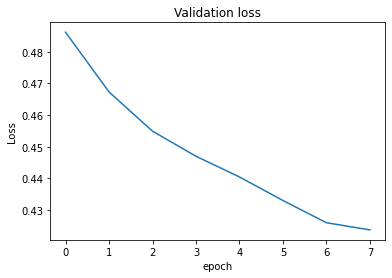

In [ ]:
plt.plot(avg_valid_losses)
plt.title('Validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

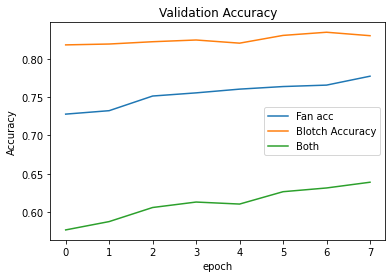

In [ ]:
plt.plot(valid_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()